In [1]:
# add the main directory to the path
import sys
sys.path.append("..")

import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from model_no_gams.model import simulate_country_averages, calculate_storage_need, get_average_profiles

logging.basicConfig(level=logging.WARNING)

In [2]:
fn_renewable: str = "../data/renewables_ninja.parquet"
fn_demand: str = "../data/renewables_with_load.parquet"

map_countries = {
    "FR": "France",
    "DE": "Germany",
    "GR": "Greece",
}

## Simulations

### Optimal RE Shares

In [3]:
countries = ["FR", "DE", "GR"]
years = range(2015,2020)
steps = 10
shares_renewable = list(np.linspace(0, 1, steps + 1))

df_opt = simulate_country_averages(
    countries=countries,
    shares_renewable=shares_renewable,
    years=years,
    fn_demand=fn_demand,
    fn_renewable=fn_renewable
)

100%|██████████| 33/33 [01:18<00:00,  2.39s/it]

Solve 33 scenarios in : 79.01 seconds.
Failed to solve 0 of 33 scenarios


### Given RE Shares


In [4]:

years = range(2015, 2020)
share_wind = 0.5
total_demand = 100

lst_df = []
all_combis = [(c, s) for c in countries for s in shares_renewable]
for country, share_renewable in all_combis:
    df_profiles = get_average_profiles(
        country=country, years=years, fn_demand=fn_demand, fn_renewable=fn_renewable)
    df_ = calculate_storage_need(
            df_profiles=df_profiles, share_renewable=share_renewable, 
            share_wind=share_wind, total_demand=total_demand
        ).assign(
                country=country,
                yearWeather="average",
                yearDemand="average",
                renewableDemandShare=share_renewable,
            )
    lst_df.append(df_)
df_given = pd.concat(lst_df)
df_given

,pv,wind,demand,base,supply,netSupply,initialStorageLevel,storageLevel,MAX_STO,shareWind,renewableDemandShare,country,yearWeather,yearDemand
index,,,,,,,,,,,,,,
2023-01-01 00:00:00,0.0,0.000000,0.013433,0.011416,0.011416,-0.002017,5.476582,5.474565,7.952222,0.5,0.0,FR,average,average
2023-01-01 01:00:00,0.0,0.000000,0.013111,0.011416,0.011416,-0.001696,5.476582,5.472869,7.952222,0.5,0.0,FR,average,average
2023-01-01 02:00:00,0.0,0.000000,0.012406,0.011416,0.011416,-0.000990,5.476582,5.471879,7.952222,0.5,0.0,FR,average,average
2023-01-01 03:00:00,0.0,0.000000,0.012019,0.011416,0.011416,-0.000603,5.476582,5.471275,7.952222,0.5,0.0,FR,average,average
2023-01-01 04:00:00,0.0,0.000000,0.011834,0.011416,0.011416,-0.000418,5.476582,5.470857,7.952222,0.5,0.0,FR,average,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,0.0,0.008061,0.014697,0.000000,0.008061,-0.006636,1.927507,1.943743,4.411428,0.5,1.0,GR,average,average
2023-12-31 20:00:00,0.0,0.007899,0.012877,0.000000,0.007899,-0.004978,1.927507,1.938765,4.411428,0.5,1.0,GR,average,average
2023-12-31 21:00:00,0.0,0.007683,0.011984,0.000000,0.007683,-0.004301,1.927507,1.934464,4.411428,0.5,1.0,GR,average,average


## Plot results

### Maximum storage and renewable share

In [5]:
df_agg_opt = (
    df_opt
    .groupby(["country", "renewableDemandShare"], as_index=False)
    [["MAX_STO", "shareWind"]]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
    )
    .round(2)
)

df_agg_given = (
    df_given
    .groupby(["country", "renewableDemandShare"], as_index=False)
    [["MAX_STO", "shareWind"]]
    .mean()
    .assign(
        # convert to percentage and set RE share to zero for non-renewable scenarios
        shareWind=lambda df: (df["renewableDemandShare"] >0).astype(int)*df["shareWind"] * 100,
        renewableDemandShare=lambda df: (df["renewableDemandShare"] * 100).astype(int)
    )
    .round(2)
)


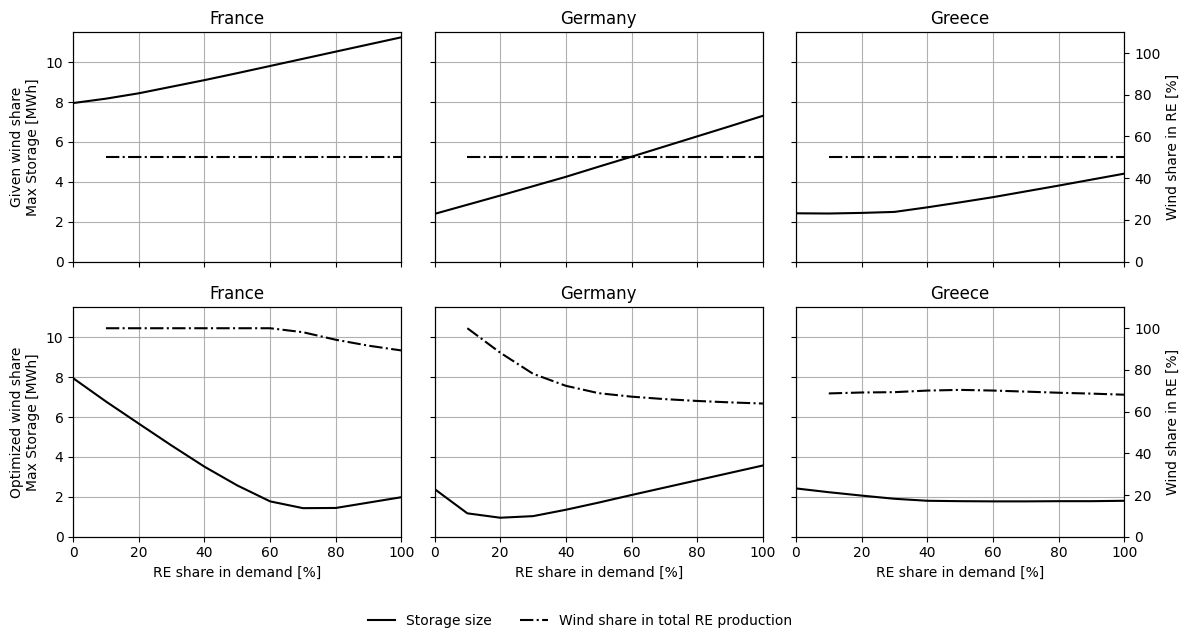

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
country = "DE"

for i, (ax, country) in enumerate(zip(axs[0], countries)):
    df_p = df_agg_given.query(f"country == '{country}'")
    sns.lineplot(x="renewableDemandShare", y="MAX_STO", data=df_p, ax=ax,
                 color="black", linestyle="-",
                 label="Storage size")
    ax.set_title(f"{map_countries[country]}")
    ax.set_xlabel("RE share in demand [%]")
    ax.set_ylabel("Given wind share\nMax Storage [MWh]")
    ax.set_ylim(0, 11.5)
    ax2 = ax.twinx()
    sns.lineplot(x="renewableDemandShare", y="shareWind", 
                 data=df_p[df_p["renewableDemandShare"] > 0], ax=ax2, 
                 color="black", linestyle="-.", 
                 label="Wind share in total RE production")
    if i == len(countries)-1:
        ax2.set_ylabel("Wind share in RE [%]")
    else:
        ax2.get_yaxis().set_ticks([])
        ax2.set_ylabel("")
    ax2.set_ylim(0, 110)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.get_legend().remove()
    ax2.get_legend().remove()

for i, (ax, country) in enumerate(zip(axs[1], countries)):
    df_p = df_agg_opt.query(f"country == '{country}'")
    sns.lineplot(x="renewableDemandShare", y="MAX_STO", data=df_p, ax=ax,
                 color="black", linestyle="-",
                 label="Storage size")
    ax.set_title(f"{map_countries[country]}")
    ax.set_xlabel("RE share in demand [%]")
    ax.set_ylabel("Optimized wind share\nMax Storage [MWh]")
    ax.set_ylim(0, 11.5)
    ax2 = ax.twinx()
    sns.lineplot(x="renewableDemandShare", y="shareWind", 
                 data=df_p[df_p["renewableDemandShare"] > 0], ax=ax2, 
                 color="black", linestyle="-.", 
                 label="Wind share in total RE production")
    if i == len(countries)-1:
        ax2.set_ylabel("Wind share in RE [%]")
    else:
        ax2.get_yaxis().set_ticks([])
        ax2.set_ylabel("")
    ax2.set_ylim(0, 110)
    ax.grid()
    ax.set_xlim(0, 100)
    ax.get_legend().remove()
    ax2.get_legend().remove()

# make a common legend merging the two legends
l1, la1 = ax.get_legend_handles_labels()
l2, la2 = ax2.get_legend_handles_labels()
fig.legend(l1 + l2, la1 + la2, loc="lower left", 
           ncol=2, bbox_to_anchor=(0.3, -0.075), frameon=False)
plt.tight_layout()
plt.savefig("../results/storage_need_average_share.png", dpi=300)


### Storage Usage

In [7]:
def boxplot_by_week(
        df:pd.DataFrame, 
        countries: list[str],
        re_shares: list[float],
        y_var: str = "netSupply",
        y_label: str = "Hourly net-generation [MWh]",
        fn_out: str | None = None
        ):
    """Provide boxplot of weekly distribution
        
        Args:
            df (pd.DataFrame): DataFrame with the data
            countries (list[str]): List of countries to plot
            re_shares (list[float]): List of renewable shares to plot
            y_var (str, optional): Variable to plot. Defaults to "netSupply".
            y_label (str, optional): Label for the y-axis. Defaults to "Hourly net-generation [MWh]".
            fn_out (str | None, optional): Filename to save the plot. Defaults to None.

        """
    _, axs = plt.subplots(
        len(re_shares), len(countries), figsize=(24, 12),
        sharey=True)
    PROPS = {
            'boxprops':{'facecolor':'none', 'edgecolor':'black'},
            'medianprops':{'color':'black'},
            'whiskerprops':{'color':'black'},
            'capprops':{'color':'black'}
        }

    for i, country in enumerate(countries):
        for j, re_share in enumerate(re_shares):
            ax = axs[j, i]
            df_p = (
                    df
                    .query(f"country == '{country}' and renewableDemandShare == {re_share}")
                    .assign(
                        week=lambda x: x.index.isocalendar().week,
                        day=lambda x: x.index.dayofyear,
                        month=lambda x: x.index.month,        
                    )
                )

            ax.set_xlim(0.5, 51)
            ax.set_ylim(-0.02, 0.02)
            ax.hlines(0, -1, 52, color="gray", linestyle="-")
            sns.boxplot(df_p, x="week", y=y_var, ax=ax, **PROPS)
            if j == 0:
                ax.set_title(f"{map_countries[country]}")
            if j == len(re_shares) - 1:
                ax.set_xlabel("Week of the year")
                ax.xaxis.set_major_locator(plt.MaxNLocator(12))
            else:
                ax.set_xlabel("")
                # remove xticks
                ax.set_xticks([])

            ax.set_ylabel(f"Renewable Share: {int(re_share*100)}%\n {y_label}")
    plt.tight_layout()
    if fn_out is not None:
        plt.savefig(fn_out, dpi=300, bbox_inches="tight")

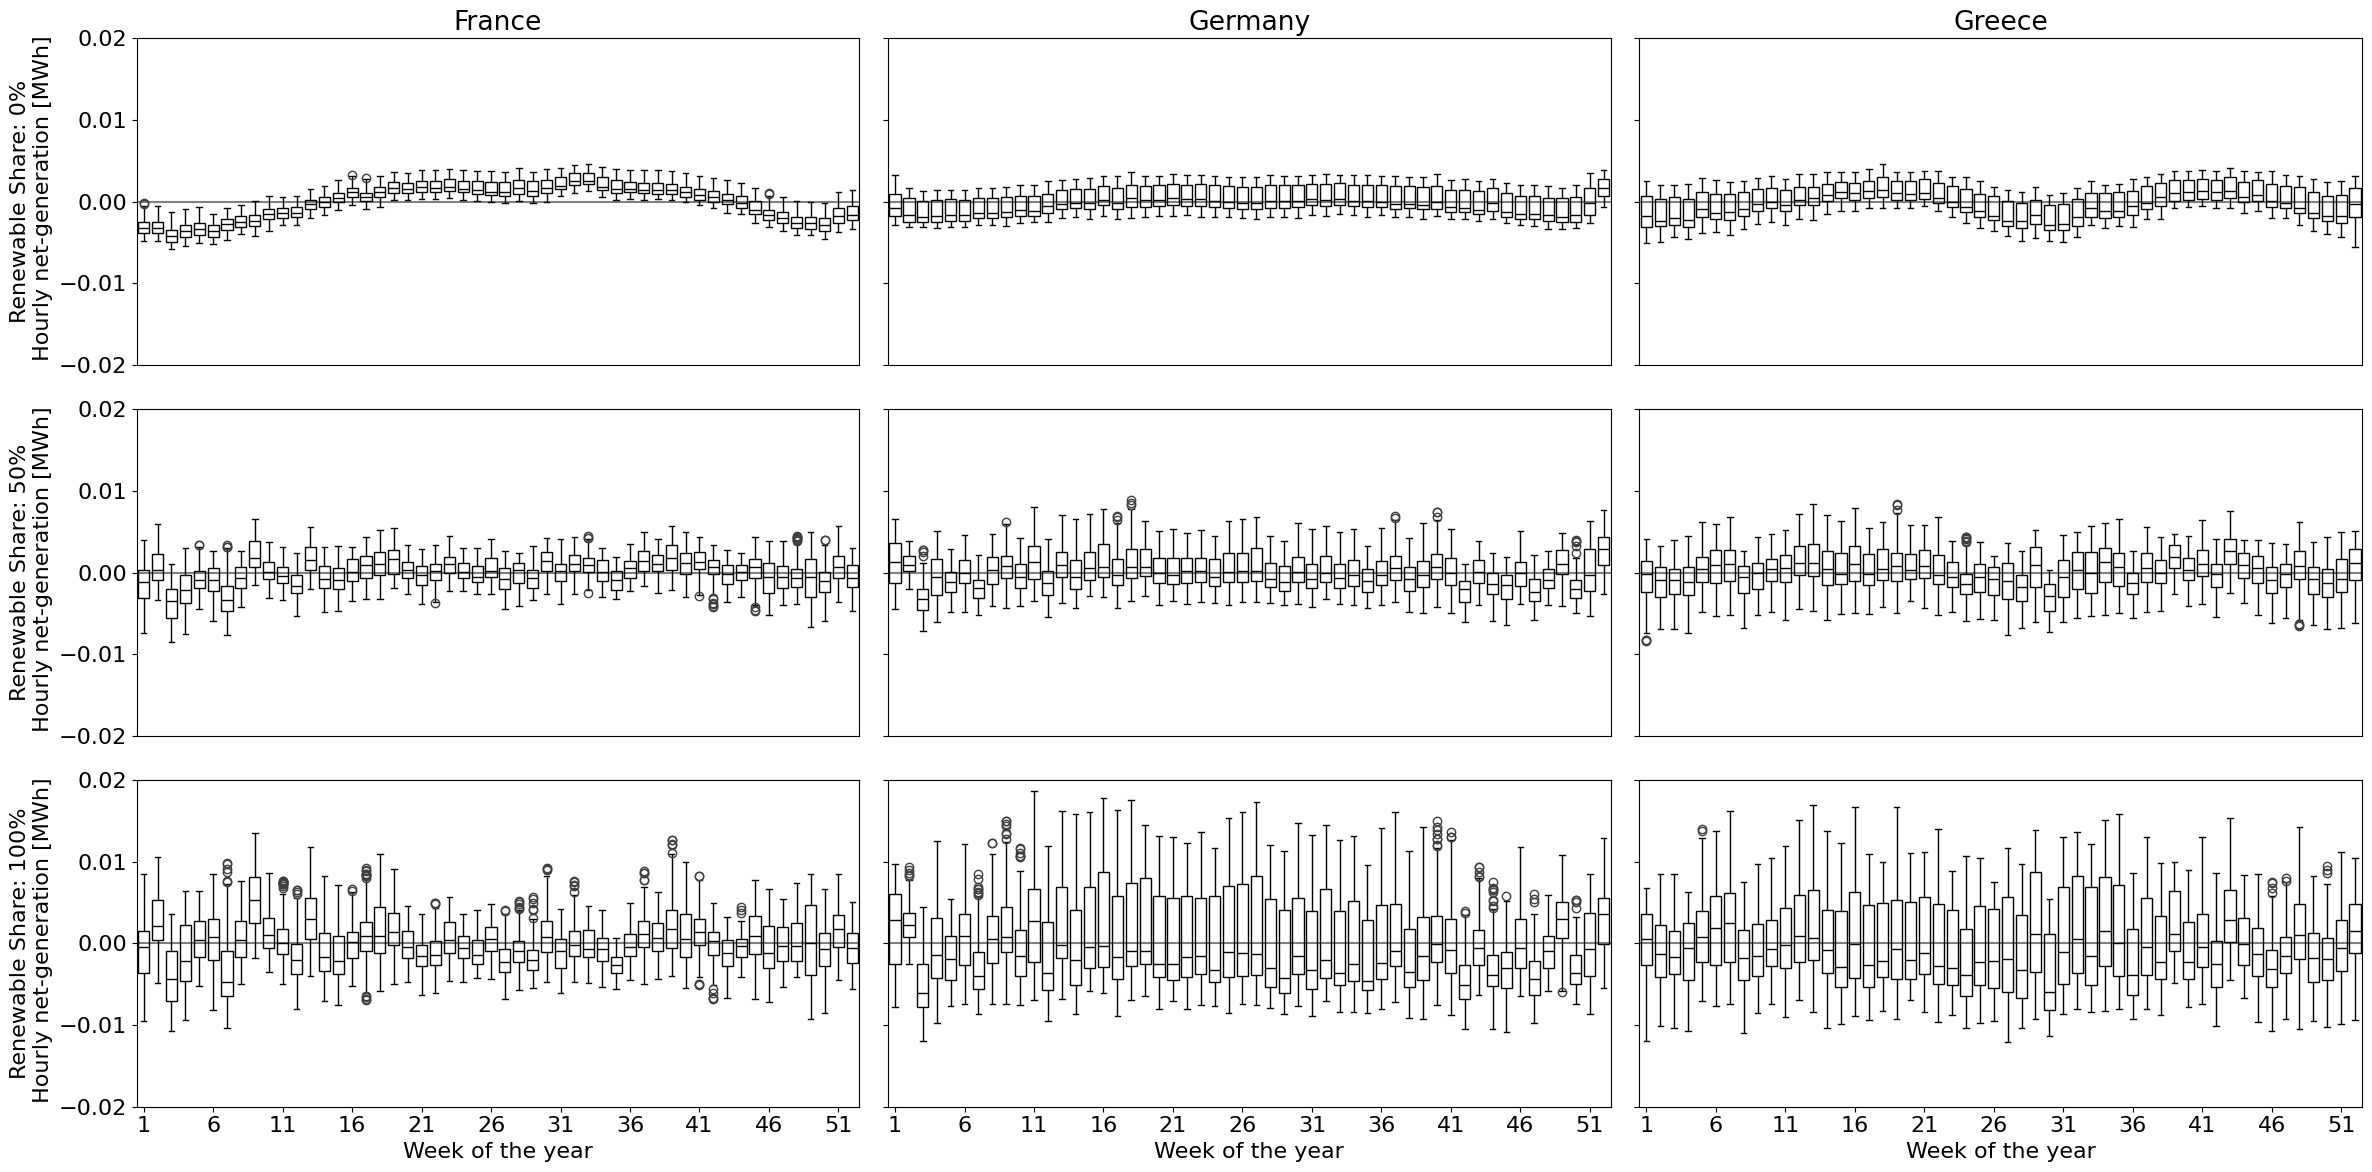

In [20]:
mpl.rcParams["font.size"] = 16
countries = ["FR", "DE", "GR"]
re_shares = [0, 0.5, 1]

y_var = "netSupply"
y_label = "Hourly net-generation [MWh]"

boxplot_by_week(df_opt, countries, re_shares, 
                y_var="netSupply", y_label="Hourly net-generation [MWh]",
                fn_out="../results/net_generation_boxplot.png")

In [9]:
boxplot_by_week(df_opt, countries, re_shares, 
                y_var="storageLevel", y_label="Hourly storage level [MWh]",
                fn_out="../results/storage_level_boxplot.png")

NameError: name 're_shares' is not defined

## Time decomposition

In [198]:
country = "DE"
re_share = 0.5
n_intervals = 365
df = (
    df_opt
    .query(f"country == '{country}'")
    .query(f"renewableDemandShare == {re_share}")
)


assert len(df)%n_intervals == 0, f"Cannot space time horizon into {n_intervals} equally spaced time intervals."
periods_per_interval = len(df_)//n_intervals
print(f"There are {periods_per_interval} hours in a period ({periods_per_interval/24} days)")
cols = ["netSupply", "storageLevel"]
df_period = (
    df
    [cols]
    .assign(
        storageBeginningPeriod=lambda df: df["storageLevel"].shift(1, fill_value=df["storageLevel"].iloc[-1]),
        storageEndPeriod=lambda df: df["storageLevel"],
    )
    .drop(columns=["storageLevel"])
)
# reindex such that the initial storage level is zero
start = df_period[df_period["storageBeginningPeriod"] == 0].index[0]
new_idx = pd.date_range(end=start, periods=len(df_period), freq="H")
df_period: pd.DataFrame = (
    pd.concat([
        df_period.loc[start:],
        df_period.loc[:start - pd.Timedelta(1, "H")]
    ])
    .set_axis(new_idx)
)

# assign intervals and compute surplus etc per interval
df_interval = (
    df_period
    .assign(interval=[i//periods_per_interval for i in range(len(df_period))])
    .groupby("interval")
    .agg(
        totalNetSupply=("netSupply", "sum"),
        minNetSupply=("netSupply", "min"),
        maxNetSupply=("netSupply", "max"),
        storageBeginningPeriod=("storageBeginningPeriod", "first"),
    )
)
df_interval#.query("interval == 0").sum()
df.MAX_STO.iloc[0], df_interval.storageBeginningPeriod.max(), df_interval.minNetSupply.min(), df_interval.maxNetSupply.max()


There are 24 hours in a period (1.0 days)


(1.7148743180568058,
 1.7031477229090264,
 -0.007131730281796664,
 0.008828023725711473)

In [199]:
0.008828023725711473 + 1.7031477229090264

1.7119757466347378

In [196]:
df_ = (
    df_period
    .assign(interval=[i//periods_per_interval for i in range(len(df_period))])
)
df_.query("interval == 0").netSupply.cumsum()

2022-12-21 12:00:00    0.000419
2022-12-21 13:00:00    0.001206
2022-12-21 14:00:00    0.001794
2022-12-21 15:00:00    0.002034
2022-12-21 16:00:00    0.001982
2022-12-21 17:00:00    0.001753
2022-12-21 18:00:00    0.001843
2022-12-21 19:00:00    0.002565
2022-12-21 20:00:00    0.004352
2022-12-21 21:00:00    0.006826
2022-12-21 22:00:00    0.009734
2022-12-21 23:00:00    0.013365
2022-12-22 00:00:00    0.017497
2022-12-22 01:00:00    0.021640
2022-12-22 02:00:00    0.025423
2022-12-22 03:00:00    0.028735
2022-12-22 04:00:00    0.031449
2022-12-22 05:00:00    0.033288
2022-12-22 06:00:00    0.033909
2022-12-22 07:00:00    0.033328
2022-12-22 08:00:00    0.032074
2022-12-22 09:00:00    0.030827
2022-12-22 10:00:00    0.029864
2022-12-22 11:00:00    0.029248
Freq: H, Name: netSupply, dtype: float64

In [197]:
df_.query("interval == 0")

,netSupply,storageBeginningPeriod,storageEndPeriod,interval
2022-12-21 12:00:00,0.000419,0.000000,0.000419,0
2022-12-21 13:00:00,0.000786,0.000419,0.001206,0
2022-12-21 14:00:00,0.000588,0.001206,0.001794,0
2022-12-21 15:00:00,0.000240,0.001794,0.002034,0
2022-12-21 16:00:00,-0.000052,0.002034,0.001982,0
2022-12-21 17:00:00,-0.000229,0.001982,0.001753,0
2022-12-21 18:00:00,0.000091,0.001753,0.001843,0
2022-12-21 19:00:00,0.000722,0.001843,0.002565,0
2022-12-21 20:00:00,0.001787,0.002565,0.004352,0
2022-12-21 21:00:00,0.002474,0.004352,0.006826,0


In [108]:
(
    df_interval
    .groupby("interval")
    .agg(
        periodNetSurplus=("netSupply", "sum")
    )
    .assign(
        periodInitialStorageLevel= lambda df: df["periodNetSurplus"].shift(1).fillna(0),
    )
)

,periodNetSurplus,periodInitialStorageLevel
interval,,
0,0.109035,0.000000
1,0.080446,0.109035
2,0.102702,0.080446
3,0.056549,0.102702
4,-0.005652,0.056549
...,...,...
360,0.047762,0.135592
361,-0.020119,0.047762
362,0.023785,-0.020119


In [141]:
df_ = (
    df
    .query(f"country == '{country}'")
    .query(f"renewableDemandShare == {re_share}")
    [cols]
    .assign(
        storageBeginningPeriod=lambda df: df["storageLevel"].shift(1, fill_value=df["storageLevel"].iloc[-1]),
        storageEndPeriod=lambda df: df["storageLevel"],
    )
    .drop(columns=["storageLevel"])
)
df_.loc[df_.storageBeginningPeriod.idxmin() - pd.Timedelta("5H"):,:].head(10)

,netSupply,storageBeginningPeriod,storageEndPeriod
index,,,
2023-12-21 06:00:00,-0.001455,0.006541,0.005086
2023-12-21 07:00:00,-0.001903,0.005086,0.003183
2023-12-21 08:00:00,-0.001657,0.003183,0.001525
2023-12-21 09:00:00,-0.001141,0.001525,0.000385
2023-12-21 10:00:00,-0.000385,0.000385,0.000000
2023-12-21 11:00:00,0.000419,0.000000,0.000419
2023-12-21 12:00:00,0.000786,0.000419,0.001206
2023-12-21 13:00:00,0.000588,0.001206,0.001794
2023-12-21 14:00:00,0.000240,0.001794,0.002034


In [122]:
df_.storageLevel.idxmin()


Timestamp('2023-12-21 10:00:00')

In [124]:
df_.to_excel("test.xlsx")